# Phase 0: Import Necessary Libraries

In [5]:
# System Info
import sys       # Access system-specific parameters and Python version
import os        # Interface with the operating system
import platform  # Get underlying platform and hardware info

# Data Processing
import numpy  # Numerical operations and arrays
import pandas as pd  # Data manipulation and analysis using DataFrames

# Visualization
import matplotlib  # Basic plotting library
import seaborn as sns  # Statistical data visualization on top of matplotlib

# Machine Learning & NLP
import sklearn  # Machine learning tools and TF-IDF baseline
import transformers  # Huggingface library for pretrained transformer models like BERT
import datasets  # Huggingface datasets library for loading NLP datasets

# Deep Learning
import torch  # PyTorch library for tensor operations and model training

# Progress Bars
import tqdm  # Show progress bars for loops and training

# Display versions
print(f"Python version      : {sys.version}")
print(f"NumPy version       : {numpy.__version__}")
print(f"Pandas version      : {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Matplotlib version  : {matplotlib.__version__}")
print(f"Seaborn version     : {sns.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Huggingface Datasets: {datasets.__version__}")
print(f"PyTorch version     : {torch.__version__}")
print(f"TQDM version        : {tqdm.__version__}")
print(f"CPU architecture    : {platform.processor() or platform.machine()}")

Python version      : 3.10.18 (main, Jun  5 2025, 08:37:47) [Clang 14.0.6 ]
NumPy version       : 1.23.5
Pandas version      : 2.3.1
Scikit-learn version: 1.7.1
Matplotlib version  : 3.10.5
Seaborn version     : 0.13.2
Transformers version: 4.30.2
Huggingface Datasets: 4.0.0
PyTorch version     : 2.7.1
TQDM version        : 4.67.1
CPU architecture    : arm


# Phase 1: Baseline Modeling

## Step 1: Load Dataset (SNLI)

In [6]:
from datasets import load_dataset

# Load SNLI dataset from HuggingFace
snli_dataset = load_dataset("snli")

# Filter out invalid labels (-1 means label not available)
def is_valid(example):
    return example['label'] != -1

snli_dataset["train"] = snli_dataset["train"].filter(is_valid)
snli_dataset["test"] = snli_dataset["test"].filter(is_valid)

# Sample: 10,000 from train, 5,000 from test
train_data = snli_dataset["train"].shuffle(seed=42).select(range(10000))
test_data = snli_dataset["test"].shuffle(seed=42).select(range(5000))

# Preview sample
print(train_data[0])


README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/413k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

{'premise': 'A group of people riding a yellow roller coaster.', 'hypothesis': 'A group of people are riding a roller coaster.', 'label': 0}


## Step 2: Preprocess + TF-IDF Vectorization

### Step 2.1: Extract texts and labels

In [7]:
# Extract features and labels
X_train = [f"{ex['premise']} [SEP] {ex['hypothesis']}" for ex in train_data]
y_train = [ex['label'] for ex in train_data]

X_test = [f"{ex['premise']} [SEP] {ex['hypothesis']}" for ex in test_data]
y_test = [ex['label'] for ex in test_data]

### Step 2.2: TF-IDF Vectorization

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit on training data and transform both sets
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


### Step 2.3 Verify shape

In [9]:
print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)


Train shape: (10000, 5000)
Test shape: (5000, 5000)


## Step 3: Train Baseline Models using TF-IDF Features

### Step 3.1: Logistic Regression – Training, Evaluation, and Error Analysis

 Logistic Regression - Classification Report:
               precision    recall  f1-score   support

   entailment       0.50      0.47      0.49      1716
      neutral       0.46      0.47      0.46      1622
contradiction       0.49      0.50      0.50      1662

     accuracy                           0.48      5000
    macro avg       0.48      0.48      0.48      5000
 weighted avg       0.48      0.48      0.48      5000



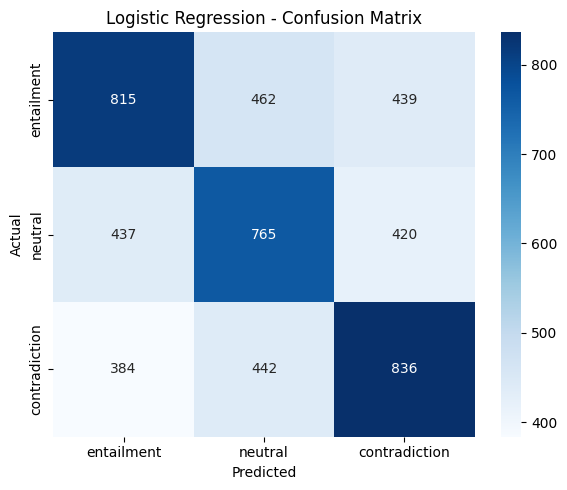


🔍 Logistic Regression – Error Examples:

Example #1
Premise    : A man in a grassy field throws a stick for a group of three brown dogs.
Hypothesis : A man is playing with dogs.
Actual     : entailment
Predicted  : contradiction

Example #2
Premise    : Two people bicycle on a path separated by small mountains.
Hypothesis : Two people are hiking up a mountain.
Actual     : contradiction
Predicted  : entailment

Example #3
Premise    : An older gentleman looks at the camera while he is building a deck.
Hypothesis : An older gentleman looks away from the camera while he is building a birdhouse.
Actual     : contradiction
Predicted  : entailment

Example #4
Premise    : A young woman cooks a meal in a wok while conversing with another woman, as an illuminated shrine to Mr. T looks on.
Hypothesis : Both of these women are clinically mute.
Actual     : contradiction
Predicted  : neutral

Example #5
Premise    : Rose petals being thrown at an asian couple.
Hypothesis : An Asian couple are t

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
labels = ["entailment", "neutral", "contradiction"]

# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_logreg = logreg_model.predict(X_test_tfidf)

# Print classification report
print(" Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_logreg, target_names=labels))

# Confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# Show 20 incorrect predictions for error analysis
print("\n🔍 Logistic Regression – Error Examples:")
count = 0
for i in range(len(y_test)):
    if y_test[i] != y_pred_logreg[i]:
        print(f"\nExample #{count+1}")
        print(f"Premise    : {test_data[i]['premise']}")
        print(f"Hypothesis : {test_data[i]['hypothesis']}")
        print(f"Actual     : {labels[y_test[i]]}")
        print(f"Predicted  : {labels[y_pred_logreg[i]]}")
        count += 1
        if count >= 20:
            break


### Step 3.2: Naive Bayes – Training, Evaluation, and Error Analysis

 Naive Bayes - Classification Report:
               precision    recall  f1-score   support

   entailment       0.45      0.47      0.46      1716
      neutral       0.47      0.41      0.43      1622
contradiction       0.47      0.51      0.49      1662

     accuracy                           0.46      5000
    macro avg       0.46      0.46      0.46      5000
 weighted avg       0.46      0.46      0.46      5000



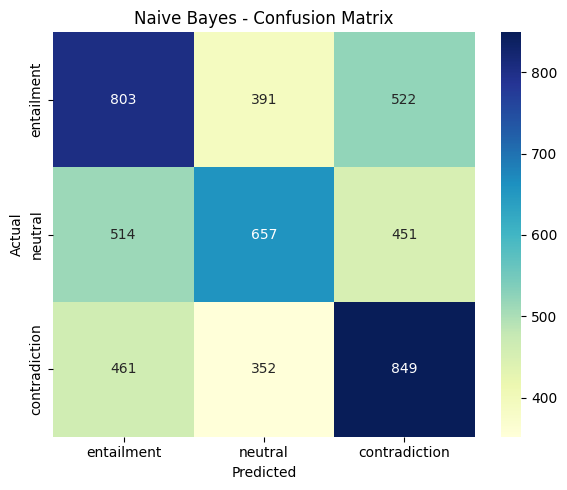


🔍 Naive Bayes – Error Examples:

Example #1
Premise    : A man is using what looks to be a fax machine.
Hypothesis : A person is using what looks to be a fax machine.
Actual     : entailment
Predicted  : neutral

Example #2
Premise    : A man in a grassy field throws a stick for a group of three brown dogs.
Hypothesis : A man is playing with dogs.
Actual     : entailment
Predicted  : contradiction

Example #3
Premise    : Two people bicycle on a path separated by small mountains.
Hypothesis : Two people are hiking up a mountain.
Actual     : contradiction
Predicted  : entailment

Example #4
Premise    : Workers wearing orange vests stand near rail tracks.
Hypothesis : Workers wearing orange are about to repair rail tracks.
Actual     : neutral
Predicted  : entailment

Example #5
Premise    : An older gentleman looks at the camera while he is building a deck.
Hypothesis : An older gentleman looks away from the camera while he is building a birdhouse.
Actual     : contradiction
Predicte

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels for display
labels = ["entailment", "neutral", "contradiction"]

# Initialize and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_nb = nb_model.predict(X_test_tfidf)

# Print classification report
print(" Naive Bayes - Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=labels))

# Confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Show 20 incorrect predictions for error analysis
print("\n🔍 Naive Bayes – Error Examples:")
count = 0
for i in range(len(y_test)):
    if y_test[i] != y_pred_nb[i]:
        print(f"\nExample #{count+1}")
        print(f"Premise    : {test_data[i]['premise']}")
        print(f"Hypothesis : {test_data[i]['hypothesis']}")
        print(f"Actual     : {labels[y_test[i]]}")
        print(f"Predicted  : {labels[y_pred_nb[i]]}")
        count += 1
        if count >= 20:
            break


### Step 3.3: Llinear SVM – Training, Evaluation, and Error Analysis

 Linear SVM - Classification Report:
               precision    recall  f1-score   support

   entailment       0.48      0.46      0.47      1716
      neutral       0.45      0.46      0.46      1622
contradiction       0.48      0.50      0.49      1662

     accuracy                           0.47      5000
    macro avg       0.47      0.47      0.47      5000
 weighted avg       0.47      0.47      0.47      5000



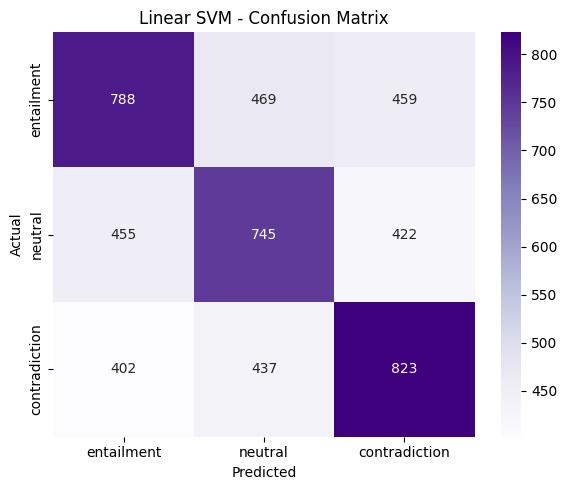


🔍 Linear SVM – Error Examples:

Example #1
Premise    : A man in a grassy field throws a stick for a group of three brown dogs.
Hypothesis : A man is playing with dogs.
Actual     : entailment
Predicted  : contradiction

Example #2
Premise    : Two people bicycle on a path separated by small mountains.
Hypothesis : Two people are hiking up a mountain.
Actual     : contradiction
Predicted  : entailment

Example #3
Premise    : Workers wearing orange vests stand near rail tracks.
Hypothesis : Workers wearing orange are about to repair rail tracks.
Actual     : neutral
Predicted  : contradiction

Example #4
Premise    : An older gentleman looks at the camera while he is building a deck.
Hypothesis : An older gentleman looks away from the camera while he is building a birdhouse.
Actual     : contradiction
Predicted  : entailment

Example #5
Premise    : A young woman cooks a meal in a wok while conversing with another woman, as an illuminated shrine to Mr. T looks on.
Hypothesis : Both of

In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
labels = ["entailment", "neutral", "contradiction"]

# Initialize and train the SVM model
svm_model = LinearSVC(max_iter=2000)
svm_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test_tfidf)

# Print classification report
print(" Linear SVM - Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=labels))

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Purples", xticklabels=labels, yticklabels=labels)
plt.title("Linear SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# Show 20 incorrect predictions for error analysis
print("\n🔍 Linear SVM – Error Examples:")
count = 0
for i in range(len(y_test)):
    if y_test[i] != y_pred_svm[i]:
        print(f"\nExample #{count+1}")
        print(f"Premise    : {test_data[i]['premise']}")
        print(f"Hypothesis : {test_data[i]['hypothesis']}")
        print(f"Actual     : {labels[y_test[i]]}")
        print(f"Predicted  : {labels[y_pred_svm[i]]}")
        count += 1
        if count >= 20:
            break


### Step 3.4 Baseline Model Comparison

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.4832,0.4841,0.4800,0.4831
1,Naive Bayes,0.4618,0.4700,0.4500,0.4606
2,Support Vector Machine,0.4712,0.4750,0.4700,0.4711


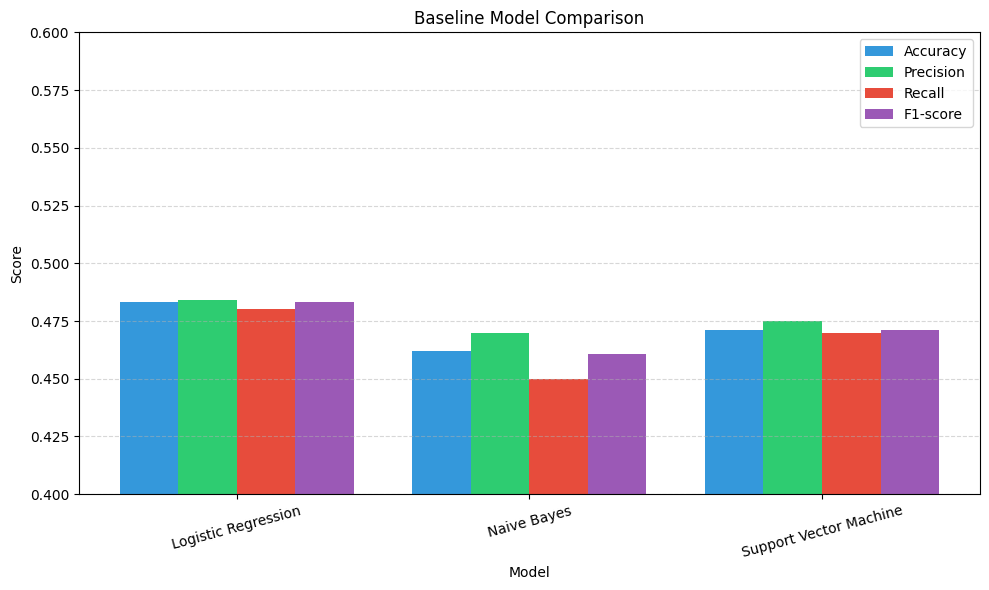

In [17]:
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt

# Fill in actual results
results = {
    "Logistic Regression": {"Accuracy": 0.4832, "Precision": 0.4841, "Recall": 0.4800, "F1-score": 0.4831},
    "Naive Bayes": {"Accuracy": 0.4618, "Precision": 0.4700, "Recall": 0.4500, "F1-score": 0.4606},
    "Support Vector Machine": {"Accuracy": 0.4712, "Precision": 0.4750, "Recall": 0.4700, "F1-score": 0.4711},
}

# Create DataFrame
df = pd.DataFrame.from_dict(results, orient="index").reset_index().rename(columns={"index": "Model"})

# Display header
display(HTML("<h3 style='text-align:left;'>📊 Baseline Model Performance</h3>"))

# Format table nicely
styled_table = df.style.set_properties(**{'text-align': 'center'}).format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-score': '{:.4f}'
}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
display(styled_table)

# Plot with distinct colors
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(len(df))

plt.bar(index, df["Accuracy"], bar_width, label="Accuracy", color="#3498db")         # Blue
plt.bar([i + bar_width for i in index], df["Precision"], bar_width, label="Precision", color="#2ecc71")  # Green
plt.bar([i + 2 * bar_width for i in index], df["Recall"], bar_width, label="Recall", color="#e74c3c")     # Red
plt.bar([i + 3 * bar_width for i in index], df["F1-score"], bar_width, label="F1-score", color="#9b59b6") # Purple

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Baseline Model Comparison")
plt.xticks([i + 1.5 * bar_width for i in index], df["Model"], rotation=15)
plt.ylim(0.4, 0.6)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
